In [1]:
!pip install pytorch_pretrained_bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Analysis


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re

In [3]:
import os
from google.colab import drive 
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/stor566')

Mounted at /content/drive


In [4]:
url = "data_final.csv"
df = pd.read_csv(url)
print(len(df))
train_raw_df, test_raw_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
train_raw_df = train_raw_df.reset_index(drop=True)
test_raw_df = test_raw_df.reset_index(drop=True)
print(len(train_raw_df))
print(len(test_raw_df))

225
157
68


In [46]:
train_raw_df['Unnamed: 0']

0       28
1       64
2       80
3      118
4       95
      ... 
152    159
153    190
154     43
155     22
156    168
Name: Unnamed: 0, Length: 157, dtype: int64

In [6]:
train_raw_df.describe()

,Unnamed: 0,label
count,157.000000,157.000000
mean,109.082803,0.159236
std,64.127773,0.367067
min,0.000000,0.000000
25%,51.000000,0.000000
50%,109.000000,0.000000
75%,164.000000,0.000000
max,223.000000,1.000000


#Data Cleaning

In [7]:
def remove_pattern(ip, pattern):
    reg_ex = re.findall(pattern, str(ip))
    for exp in reg_ex:
        ip = re.sub(exp, '', str(ip))
    return str(ip)

In [8]:
def clean_data(df):
    df['text'] = np.vectorize(remove_pattern)(df['text'], '@[\w]*')
    df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")
    df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [9]:
clean_data(train_raw_df)
clean_data(test_raw_df)
train_raw_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,text,label
0,28,humans climate change make wildfires even more...,0
1,64,After months Deal Mexico Deal Iran Deal Canada...,0
2,80,Turnbull leadership sham seeks evade GBRF scan...,0
3,118,After months Deal Mexico Deal Iran Deal Canada...,0
4,95,last thing these endangered orcas need tarsand...,0


In [10]:
train_df = pd.DataFrame({'id': range(len(train_raw_df)),
                         'label': train_raw_df['label'],
                         'alpha': ['a']*train_raw_df.shape[0],
                         'text': train_raw_df['text'].replace(r'\n', ' ', regex=True)})
test_df = pd.DataFrame({'id': range(len(test_raw_df)),
                        'label': test_raw_df['label'],
                        'alpha': ['a']*test_raw_df.shape[0],
                        'text': test_raw_df['text'].replace(r'\n', ' ', regex=True)})
train_df.head()

,id,label,alpha,text
0,0,0,a,humans climate change make wildfires even more...
1,1,0,a,After months Deal Mexico Deal Iran Deal Canada...
2,2,0,a,Turnbull leadership sham seeks evade GBRF scan...
3,3,0,a,After months Deal Mexico Deal Iran Deal Canada...
4,4,0,a,last thing these endangered orcas need tarsand...


In [47]:
train_df

,id,label,alpha,text
0,0,0,a,humans climate change make wildfires even more...
1,1,0,a,After months Deal Mexico Deal Iran Deal Canada...
2,2,0,a,Turnbull leadership sham seeks evade GBRF scan...
3,3,0,a,After months Deal Mexico Deal Iran Deal Canada...
4,4,0,a,last thing these endangered orcas need tarsand...
...,...,...,...,...
152,152,0,a,appeal youngsters Innovate India Innovate huma...
153,153,1,a,global warming computer that predicted frozen ...
154,154,1,a,These cities successfully leveraging transport...
155,155,0,a,defies form rational responsible decision maki...


In [11]:
train_df.to_csv('train.tsv', sep='\t', index=False, header=False)
test_df.to_csv('dev.tsv', sep='\t', index=False, header=False)

#Data preprocessing

In [12]:
import torch
import pickle
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.nn import CrossEntropyLoss, MSELoss

from tqdm import tqdm_notebook, trange
import os
import csv 
import sys
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

from multiprocessing import Pool, cpu_count

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [13]:
class InputExample(object):
    def __init__(self, guid, text, label=None):
        self.guid = guid
        self.text = text
        self.label = label


class DataProcessor(object):
    def get_train_examples(self, data_dir):
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        raise NotImplementedError()

    def get_labels(self):
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        with open(input_file, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines


class BinaryClassificationProcessor(DataProcessor):
    def get_train_examples(self, data_dir):
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text = line[3]
            label = line[1]
            examples.append(
                InputExample(guid=guid, text=text, label=label))
        return examples


In [14]:
class InputFeatures(object):
    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


def _truncate_seq_pair(tokens, max_length):
    while True:
        if len(tokens) <= max_length:
            break
        else:
            tokens.pop()


def convert_example_to_feature(example_row):
    example, label_map, max_seq_length, tokenizer = example_row

    tokens = tokenizer.tokenize(example.text)        
    
    if len(tokens) > max_seq_length - 2:
            tokens = tokens[:(max_seq_length - 2)]

    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    segment_ids = [0] * len(tokens)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding = [0] * (max_seq_length - len(input_ids))
    input_ids += padding
    input_mask += padding
    segment_ids += padding

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    label_id = label_map[example.label]
    
    return InputFeatures(input_ids=input_ids,
                         input_mask=input_mask,
                         segment_ids=segment_ids,
                         label_id=label_id)

In [15]:
processor = BinaryClassificationProcessor()
train_examples = processor.get_train_examples('.')
train_examples_len = len(train_examples)

In [16]:
label_list = processor.get_labels()
num_labels = len(label_list)

In [17]:
MAX_SEQ_LENGTH = 128

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 416386.12B/s]


In [19]:
label_map = {label: i for i, label in enumerate(label_list)}
train_examples_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer) for example in train_examples]

In [20]:
process_count = cpu_count() - 1
if __name__ ==  '__main__':
    print(f'Preparing to convert {train_examples_len} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        train_features = list(tqdm_notebook(p.imap(convert_example_to_feature, train_examples_for_processing), total=train_examples_len))

Preparing to convert 157 examples..
Spawning 3 processes..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/157 [00:00<?, ?it/s]

In [21]:
with open("train_features.pkl", "wb") as f:
    pickle.dump(train_features, f)

# Creating the model

In [22]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", cache_dir="/content/cache", num_labels=num_labels)

100%|██████████| 407873900/407873900 [00:28<00:00, 14489730.14B/s]


In [23]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [24]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

In [25]:
TRAIN_BATCH_SIZE = 4
EVAL_BATCH_SIZE = 4
LEARNING_RATE = 2e-7
NUM_TRAIN_EPOCHS = 15
RANDOM_SEED = 42
GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1

num_train_optimization_steps = int(train_examples_len / TRAIN_BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS) * NUM_TRAIN_EPOCHS
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP_PROPORTION,
                     t_total=num_train_optimization_steps)

In [26]:
global_step = 0
nb_tr_steps = 0
tr_loss = 0

In [27]:
all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)

In [28]:
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=TRAIN_BATCH_SIZE)

#Training the model

In [29]:
model.train()
loss_total = []
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm_notebook(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        logits = model(input_ids, segment_ids, input_mask, labels=None)

        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        
        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        print("\r Loss: %f" % loss, end='')
        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
    loss_total.append(loss.data)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

 Loss: 0.816626

/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


 Loss: 0.740737

Epoch:   7%|▋         | 1/15 [00:09<02:10,  9.31s/it]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

 Loss: 0.708991

Epoch:  13%|█▎        | 2/15 [00:15<01:40,  7.75s/it]

 Loss: 0.746701

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

 Loss: 0.646352

Epoch:  20%|██        | 3/15 [00:22<01:27,  7.26s/it]

 Loss: 0.811215

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

 Loss: 0.636737

Epoch:  27%|██▋       | 4/15 [00:29<01:17,  7.06s/it]

 Loss: 0.503271

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

 Loss: 0.566987

Epoch:  33%|███▎      | 5/15 [00:36<01:09,  6.96s/it]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

 Loss: 0.669503

Epoch:  40%|████      | 6/15 [00:42<01:02,  6.90s/it]

 Loss: 0.568414

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

 Loss: 0.470612

Epoch:  47%|████▋     | 7/15 [00:49<00:55,  6.88s/it]

 Loss: 0.852741

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

 Loss: 0.663299

Epoch:  53%|█████▎    | 8/15 [00:56<00:48,  6.89s/it]

 Loss: 0.584867

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

 Loss: 0.410509

Epoch:  60%|██████    | 9/15 [01:03<00:41,  6.90s/it]

 Loss: 0.472551

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

 Loss: 0.472013

Epoch:  67%|██████▋   | 10/15 [01:10<00:34,  6.92s/it]

 Loss: 0.392630

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

 Loss: 0.580949

Epoch:  73%|███████▎  | 11/15 [01:17<00:27,  6.93s/it]

 Loss: 0.360595

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

 Loss: 0.522495

Epoch:  80%|████████  | 12/15 [01:24<00:20,  6.93s/it]

 Loss: 0.361236

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

 Loss: 0.263632

Epoch:  87%|████████▋ | 13/15 [01:31<00:13,  6.92s/it]

 Loss: 0.357370

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

 Loss: 0.569337

Epoch:  93%|█████████▎| 14/15 [01:38<00:06,  6.92s/it]

 Loss: 0.320399

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

 Loss: 0.400601

 Loss: 0.376481

 Loss: 0.376044

 Loss: 0.645201

 Loss: 0.447182

 Loss: 0.366216

 Loss: 0.410011

Epoch: 100%|██████████| 15/15 [01:45<00:00,  6.90s/it]

 Loss: 0.417318

Epoch: 100%|██████████| 15/15 [01:45<00:00,  7.01s/it]


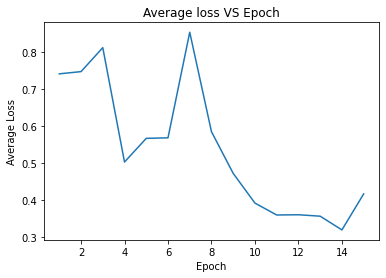

<Figure size 432x288 with 0 Axes>

In [45]:
'''model_to_save = model.module if hasattr(model, 'module') else model

CONFIG_NAME = "config.json"
WEIGHTS_NAME = "pytorch_model.bin"

output_model_file = os.path.join('./output', WEIGHTS_NAME)
output_config_file = os.path.join('./output', CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary('./output')'''
import matplotlib.pyplot as plt
tmmpp = []
for ll in loss_total:
  tmmpp.append(ll.cpu())
epoch_count = range(1, len(loss_total) + 1)
plt.plot(epoch_count, tmmpp)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title("Average loss VS Epoch")
plt.show()
plt.savefig("output.jpg")

In [31]:
loss_total

[tensor(0.7407, device='cuda:0'),
 tensor(0.7467, device='cuda:0'),
 tensor(0.8112, device='cuda:0'),
 tensor(0.5033, device='cuda:0'),
 tensor(0.5670, device='cuda:0'),
 tensor(0.5684, device='cuda:0'),
 tensor(0.8527, device='cuda:0'),
 tensor(0.5849, device='cuda:0'),
 tensor(0.4726, device='cuda:0'),
 tensor(0.3926, device='cuda:0'),
 tensor(0.3606, device='cuda:0'),
 tensor(0.3612, device='cuda:0'),
 tensor(0.3574, device='cuda:0'),
 tensor(0.3204, device='cuda:0'),
 tensor(0.4173, device='cuda:0')]

In [32]:
processor = BinaryClassificationProcessor()
test_examples = processor.get_dev_examples('.')
test_examples_len = len(test_examples)

In [33]:
test_examples_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer) for example in test_examples]

In [34]:
process_count = cpu_count() - 1
if __name__ ==  '__main__':
    print(f'Preparing to convert {test_examples_len} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        test_features = list(tqdm_notebook(p.imap(convert_example_to_feature, test_examples_for_processing), total=test_examples_len))

Preparing to convert 68 examples..
Spawning 3 processes..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/68 [00:00<?, ?it/s]

In [35]:
with open("test_features.pkl", "wb") as f:
    pickle.dump(test_features, f)

In [36]:
all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in test_features], dtype=torch.long)

In [37]:
test_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=TRAIN_BATCH_SIZE)
list_temp = []
for j in test_dataloader:
  list_temp.append(j[3])
list_temp

[tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 0, 1, 0]),
 tensor([0, 0, 1, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 1, 0, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 1, 0, 1]),
 tensor([0, 0, 1, 0]),
 tensor([0, 0, 0, 0]),
 tensor([0, 1, 1, 0]),
 tensor([0, 0, 0, 0]),
 tensor([1, 0, 0, 0]),
 tensor([0, 1, 0, 0]),
 tensor([0, 1, 0, 0])]

In [64]:
total_correct = 0
for step, batch in enumerate(tqdm_notebook(test_dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        logits = model(input_ids, segment_ids, input_mask, labels=None)
        prediction = torch.nn.functional.softmax(logits,dim =1)
        temp = list_temp[step]
        #print(prediction)
        for k in range(len(temp)):
          #print(temp[k])
          #print(torch.argmax(prediction[k]))
          if temp[k] == torch.argmax(prediction[k]):
            total_correct += 1
          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Iteration:   0%|          | 0/17 [00:00<?, ?it/s]

In [59]:
total_correct/(68)


0.8382352941176471

In [142]:

def new_observation(text):
   test_temp = pd.DataFrame({'id': [0],
                        'label': [1],
                        'alpha': ['a'],
                        'text': [text.replace(r'\n', ' ')]})
   test_temp.to_csv('dev.tsv', sep='\t', index=False, header=False)
   temp_processor = BinaryClassificationProcessor()
   test_examples_temp = temp_processor.get_dev_examples('.')
   test_examples_temp_len = len(test_examples_temp)
   test_examples_temp_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer) for example in test_examples_temp]
   process_count_temp = cpu_count() - 1
   with Pool(process_count_temp) as p:
        test_features_temp = list(tqdm_notebook(p.imap(convert_example_to_feature, test_examples_temp_for_processing), total=test_examples_temp_len))
   all_input_ids_temp = torch.tensor([f.input_ids for f in test_features_temp], dtype=torch.long)
   all_input_mask_temp = torch.tensor([f.input_mask for f in test_features_temp], dtype=torch.long)
   all_segment_ids_temp = torch.tensor([f.segment_ids for f in test_features_temp], dtype=torch.long)
   all_label_ids_temp = torch.tensor([f.label_id for f in test_features_temp], dtype=torch.long)
   test_data_temp = TensorDataset(all_input_ids_temp, all_input_mask_temp, all_segment_ids_temp, all_label_ids_temp)
   test_sampler_temp = RandomSampler(test_data_temp)
   test_dataloader_temp = DataLoader(test_data_temp, sampler=test_sampler_temp, batch_size=1)
   for step, batch in enumerate(tqdm_notebook(test_dataloader_temp, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        logits = model(input_ids, segment_ids, input_mask, labels=None)
        
        prediction_temp = torch.nn.functional.softmax(logits,dim =1)
        prediction_temp[0][1] = prediction_temp[0][1] + 0.14

        prediction_temp[0][0]= prediction_temp[0][0] - 0.14
        print(prediction_temp)
   return (torch.argmax(prediction_temp).cpu())


new_observation("RT @PaulEDawson: Policies that choke off fossil fuels at their origin — shutting down mines and wells; banning new ones; opting against new…")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([[0.5532, 0.4468]], device='cuda:0', grad_fn=<CopySlices>)


tensor(0)

In [106]:
prediction_temp

NameError: ignored